In [1]:
from datasets import load_dataset, Image
import os
import numpy as np

root_dir = './NIH-small/sample/'

dataset = load_dataset('imagefolder', split='train', data_dir=os.path.join(root_dir, 'images'))
# Add a filename column
def add_filename(example):
    example['filename'] = os.path.basename(example['image'].filename)
    return example

dataset = dataset.map(add_filename)

dataset = dataset.cast_column("image", Image(mode="RGB"))

# Load the metadata from the CSV file
import pandas as pd
metadata_file = os.path.join(root_dir, 'sample_labels.csv')
# Load the metadata from the CSV file
metadata_df = pd.read_csv(metadata_file)

# Create a dictionary from the metadata for quick lookup
metadata_dict = metadata_df.set_index('Image Index').to_dict(orient='index')

# Add metadata to the dataset
def add_metadata(example):
    filename = example['filename']
    if filename in metadata_dict:
        metadata = metadata_dict[filename]
        example.update(metadata)
    return example

dataset = dataset.map(add_metadata)

from datasets.features import ClassLabel, Sequence

# Split "Finding Labels" into multiple labels
metadata_df['Finding Labels'] = metadata_df['Finding Labels'].str.split('|')

# Get all unique labels
all_labels = set(label for sublist in metadata_df['Finding Labels'] for label in sublist)
# as no finding label affects so many images, most implementations remove "no finding" label.
all_labels.remove('No Finding')

# ### #TODO: only select some labels
# all_labels = set(['Infiltration', 'Effusion', 'Atelectasis', 'Nodule', 'Pneumothorax']) 

# Create a ClassLabel feature for each unique label
class_labels = ClassLabel(names=list(all_labels))

# Define the label feature as a sequence of ClassLabel
labels_type = Sequence(class_labels)
num_labels = len(class_labels.names)


# # Remove unnecessary columns if needed
# dataset = dataset.remove_columns(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender'])

# Create a dictionary from the metadata for quick lookup
metadata_dict = metadata_df.set_index('Image Index').to_dict(orient='index')

# Add metadata to the dataset, including the sequence of class labels
def add_metadata(example):
    filename = example['filename']
    if filename in metadata_dict:
        metadata = metadata_dict[filename]
        example.update(metadata)
        # example['labels_list'] = [class_labels.str2int(label) if label in class_labels.names else 'No Finding' for label in metadata['Finding Labels']]
        example['labels'] = [float(class_labels.int2str(x) in metadata['Finding Labels']) for x in range(num_labels)]
    return example

# Apply the metadata and features to the dataset
dataset = dataset.map(add_metadata)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Resolving data files:   0%|          | 0/5606 [00:00<?, ?it/s]

Map:   0%|          | 0/5606 [00:00<?, ? examples/s]

In [2]:
# # filter data with no finding label; we can also down-sample it.
dataset_only_finding = dataset.filter(lambda example: sum(example['labels']) >= 1.0)
print(len(dataset), len(dataset_only_finding))
dataset = dataset_only_finding

Filter:   0%|          | 0/5606 [00:00<?, ? examples/s]

5606 2562


### data split
train : valid : test with ratio of 6:2:2.


In [3]:
train_testvalid = dataset.train_test_split(test_size=0.4, seed=42)
train_ds = train_testvalid['train']
test_valid = train_testvalid['test'].train_test_split(test_size=0.5, seed=42)
val_ds = test_valid['train']
test_ds = test_valid['test']

### Preprocessing the data
We will now preprocess the data. The model requires 2 things: pixel_values and labels.

We will perform data augmentaton on-the-fly using HuggingFace Datasets' set_transform method (docs can be found here). This method is kind of a lazy map: the transform is only applied when examples are accessed. This is convenient for tokenizing or padding text, or augmenting images at training time for example, as we will do here.

In [4]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)
import torch
import torch.nn as nn

size = 224

_train_transforms = Compose(
        [
            # RandomResizedCrop(size),
            # RandomHorizontalFlip(),
            Resize(size),
            ToTensor(),
            # normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            # CenterCrop(size),
            ToTensor(),
            # normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [5]:
# from monai.transforms import (
#     Activations,
#     EnsureChannelFirst,
#     AsDiscrete,
#     Compose,
#     LoadImage,
#     RandFlip,
#     RandRotate,
#     RandZoom,
#     ScaleIntensity,
# )
# import torch
# import torch.nn as nn

# # # following: https://github.com/Project-MONAI/tutorials/blob/main/2d_classification/mednist_tutorial.ipynb

# _train_transforms = Compose(
#     [
#         RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
#         RandFlip(spatial_axis=0, prob=0.5),
#         RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
#     ]
# )

# _val_transforms = Compose([])

# def train_transforms(examples):
#     examples['pixel_values'] = [_train_transforms(image) for image in examples['image']]
#     return examples

# def val_transforms(examples):
#     examples['pixel_values'] = [_val_transforms(image) for image in examples['image']]
#     return examples

# # Set the transforms
# train_ds.set_transform(train_transforms)
# val_ds.set_transform(val_transforms)
# test_ds.set_transform(val_transforms)

In [6]:
# from monai.transforms import LoadImageD, EnsureChannelFirstD, ScaleIntensityD, Compose

# transform = Compose(
#     [
#         LoadImageD(keys="image", image_only=True),
#         EnsureChannelFirstD(keys="image"),
#         ScaleIntensityD(keys="image"),
#     ]
# )
# transform(train_ds[0]['image'])

In [7]:
from torch.utils.data import DataLoader

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples]).to(device)
    labels = torch.tensor([example["labels"] for example in examples]).to(device).float() # change for one-hot multilabels
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)
val_dataloader = DataLoader(val_ds, collate_fn=collate_fn, batch_size=4)

In [8]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)
    if k == 'labels':
      print(v)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4, 14])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='mps:0')


### Define the model

In [9]:
import torchvision.models as models

# Define the model
class ResNetMultiLabel(nn.Module):
    def __init__(self, num_classes):
        super(ResNetMultiLabel, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
        
    def forward(self, x):
        return self.resnet(x)

# Instantiate the model
model = ResNetMultiLabel(num_labels).to(device)

/Users/huangjin/opt/anaconda3/envs/ViT/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/huangjin/opt/anaconda3/envs/ViT/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Visualize the model

In [10]:
# def compute_freq(ground_labels):
#     num_samples = ground_labels.shape[0]
#     pos_samples = np.sum(ground_labels,axis=0)
#     neg_samples = num_samples-pos_samples
#     pos_samples = pos_samples/float(num_samples)
#     neg_samples = neg_samples/float(num_samples)
#     return pos_samples, neg_samples

# ground_labels = []
# for i in train_ds:
#     ground_labels.append(i['labels'])
# ground_labels = np.array(ground_labels)
# print(ground_labels.shape)
# freq_pos, freq_neg = compute_freq(ground_labels)

# freq_pos, freq_neg

In [11]:
from transformers import TrainingArguments, Trainer
from torch import nn
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from tqdm import trange
from tqdm.notebook import tqdm


# # Loss function and optimizer; @TODO: Alternative way is to find the best thresholds for labels on the validation set.
# weights = np.array(freq_neg, dtype=np.float32) / np.array(freq_pos, dtype=np.float32)
# criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(weights, dtype=torch.float).to(device))

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.0
    last_loss = 0.
    pbar = tqdm(enumerate(train_dataloader), unit="batch", total=len(train_dataloader))
    for i, data in pbar:
        inputs, labels = data['pixel_values'], data['labels']
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        pbar.set_description('  batch {} loss: {}'.format(i + 1, loss.item()))
        if i % 10 == 9:
            last_loss = running_loss / 10 # loss per batch
            # pbar.set_description('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_dataloader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('logs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 10

best_vloss = 1_000_000.

pbar = trange(EPOCHS)
for epoch in pbar:
    pbar.set_description('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    running_vloss = 0.0
    roc_auc, f1 = 0.0, 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(val_dataloader):
            vinputs, vlabels = vdata['pixel_values'], vdata['labels']
            voutputs = model(vinputs)
            vloss = criterion(voutputs, vlabels)
            vprobs = torch.sigmoid(voutputs).cpu().numpy()
            y_preds = np.zeros(vprobs.shape)
            y_preds[np.where(vprobs >= 0.5)] = 1
            roc_auc += roc_auc_score(vlabels.cpu().numpy(), vprobs, average = 'micro')
            f1 += f1_score(vlabels.cpu().numpy(), y_preds, average = 'micro')
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {} valid_roc_auc {} valid_f1 {}'.format(avg_loss, avg_vloss, roc_auc / len(val_dataloader), f1 / len(val_dataloader)))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

/Users/huangjin/opt/anaconda3/envs/ViT/lib/python3.9/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/Users/huangjin/opt/anaconda3/envs/ViT/lib/python3.9/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
EPOCH 1::   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/385 [00:00<?, ?batch/s]

EPOCH 2::  10%|█         | 1/10 [00:57<08:41, 57.89s/it]

LOSS train 0.30316309332847596 valid 0.28858596086502075 valid_roc_auc 0.7997950804380415 valid_f1 0.1855411949161948


  0%|          | 0/385 [00:00<?, ?batch/s]

EPOCH 3::  20%|██        | 2/10 [01:54<07:34, 56.87s/it]

LOSS train 0.223697267472744 valid 0.311373233795166 valid_roc_auc 0.7821239074953338 valid_f1 0.2607343496474928


  0%|          | 0/385 [00:00<?, ?batch/s]

EPOCH 4::  30%|███       | 3/10 [02:49<06:34, 56.36s/it]

LOSS train 0.09933514297008514 valid 0.3459261655807495 valid_roc_auc 0.7686235991023168 valid_f1 0.3043338312524893


  0%|          | 0/385 [00:00<?, ?batch/s]

EPOCH 5::  40%|████      | 4/10 [03:47<05:40, 56.70s/it]

LOSS train 0.07085093036293984 valid 0.40062621235847473 valid_roc_auc 0.6961210545090329 valid_f1 0.23949041409978902


  0%|          | 0/385 [00:00<?, ?batch/s]

EPOCH 6::  50%|█████     | 5/10 [04:43<04:43, 56.62s/it]

LOSS train 0.05003390647470951 valid 0.3828139007091522 valid_roc_auc 0.739586269727854 valid_f1 0.3015326622766637


  0%|          | 0/385 [00:00<?, ?batch/s]

EPOCH 7::  60%|██████    | 6/10 [05:39<03:45, 56.47s/it]

LOSS train 0.041638802736997604 valid 0.40543124079704285 valid_roc_auc 0.7414713231456472 valid_f1 0.26870254311660546


  0%|          | 0/385 [00:00<?, ?batch/s]

EPOCH 8::  70%|███████   | 7/10 [06:36<02:49, 56.56s/it]

LOSS train 0.0338793683797121 valid 0.42156872153282166 valid_roc_auc 0.7500112944913842 valid_f1 0.31191944544426137


  0%|          | 0/385 [00:00<?, ?batch/s]

EPOCH 9::  80%|████████  | 8/10 [07:33<01:53, 56.66s/it]

LOSS train 0.025895066931843756 valid 0.43611279129981995 valid_roc_auc 0.730475573659464 valid_f1 0.30953201720664947


  0%|          | 0/385 [00:00<?, ?batch/s]

EPOCH 10::  90%|█████████ | 9/10 [08:30<00:56, 56.83s/it]

LOSS train 0.02404321953654289 valid 0.4388706088066101 valid_roc_auc 0.7229068950284728 valid_f1 0.3045433987989132


  0%|          | 0/385 [00:00<?, ?batch/s]

EPOCH 10:: 100%|██████████| 10/10 [09:27<00:00, 56.76s/it]

LOSS train 0.0179381319321692 valid 0.4592209756374359 valid_roc_auc 0.7186163536604526 valid_f1 0.304054050779694


### Evaluate on Testds 
Consider metrics for multi-class classification


In [25]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import EvalPrediction
    
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5, verbose=1):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    probs = torch.sigmoid(predictions).cpu().numpy()
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, probs, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    if verbose:
        print(classification_report(y_true=y_true.astype(int), y_pred=y_pred, target_names=class_labels.names))
    # labels = train_ds.features['labels_list']
    # cm = confusion_matrix(y_true, y_pred)
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    # disp.plot(xticks_rotation=45)

    return metrics
        


In [13]:
## Tuning threshold on val_ds: https://vitaliset.github.io/threshold-dependent-opt/ on f_1 metric
## TODO: we can also use roc_curve to decide the best threshold: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
def optimize_threshold_metric(model, val_dataloader, threshold_grid=None):
    y_true = torch.tensor([], dtype=torch.long)
    predictions = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for i, vdata in tqdm(enumerate(val_dataloader), unit="batch", total=len(val_dataloader)):
            vinputs, vlabels = vdata['pixel_values'], vdata['labels'].cpu()
            voutputs = model(vinputs).cpu()
            predictions = torch.cat((predictions, voutputs), 0)
            y_true = torch.cat((y_true, vlabels), 0)

    if threshold_grid is None:
        threshold_grid = np.arange(0.01, 1, 0.01)
    optimal_thresholds = np.zeros(num_labels)
    for i in range(num_labels):
        best_threshold = 0.5
        best_f1 = 0
        for threshold in threshold_grid:
            probs = torch.sigmoid(predictions).cpu().numpy()
            # next, use threshold to turn them into integer predictions
            y_pred = np.zeros(probs.shape)
            y_pred[np.where(probs >= threshold)] = 1
            f1 = f1_score(y_true[:, i], y_pred[:, i], average='binary')
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
        optimal_thresholds[i] = best_threshold
    print("Optimal thresholds for each category:", optimal_thresholds)
    return optimal_thresholds


thresholds = optimize_threshold_metric(model, val_dataloader)

  0%|          | 0/128 [00:00<?, ?batch/s]

Optimal thresholds for each category: [0.06 0.02 0.04 0.11 0.12 0.37 0.36 0.01 0.5  0.44 0.04 0.07 0.01 0.16]


In [104]:
def evaluate(test_dataloader, threshold=0.5, verbose=1):
    y_true = torch.tensor([], dtype=torch.long)
    y_pred = torch.tensor([])
    with torch.no_grad():
        for i, vdata in tqdm(enumerate(test_dataloader), unit="batch", total=len(test_dataloader)):
            vinputs, vlabels = vdata['pixel_values'], vdata['labels'].cpu()
            voutputs = model(vinputs).cpu()
            y_pred = torch.cat((y_pred, voutputs), 0)
            y_true = torch.cat((y_true, vlabels), 0)
    return multi_label_metrics(y_pred, y_true.numpy(), threshold=threshold, verbose=verbose)

test_dataloader = DataLoader(test_ds, collate_fn=collate_fn, batch_size=32)
evaluate(test_dataloader, threshold=thresholds)

  0%|          | 0/17 [00:00<?, ?batch/s]

                    precision    recall  f1-score   support

          Fibrosis       0.00      0.00      0.00        20
         Emphysema       0.20      0.46      0.28        28
     Consolidation       0.10      0.26      0.14        47
             Edema       0.10      0.24      0.14        25
            Nodule       0.19      0.24      0.21        59
      Cardiomegaly       0.47      0.25      0.33        28
      Pneumothorax       0.38      0.24      0.30        66
          Effusion       0.37      0.62      0.47       133
            Hernia       0.00      0.00      0.00         5
              Mass       0.25      0.12      0.16        68
       Atelectasis       0.35      0.55      0.43       107
Pleural_Thickening       0.06      0.08      0.06        39
         Pneumonia       0.03      0.36      0.05        11
      Infiltration       0.41      0.73      0.52       187

         micro avg       0.26      0.44      0.33       823
         macro avg       0.21      0.3

/Users/huangjin/opt/anaconda3/envs/ViT/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/huangjin/opt/anaconda3/envs/ViT/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'f1': 0.32909090909090905,
 'roc_auc': 0.7106333347154663,
 'accuracy': 0.056530214424951264}

In [15]:
evaluate(test_dataloader, threshold=0.5)

  0%|          | 0/17 [00:00<?, ?batch/s]

                    precision    recall  f1-score   support

          Fibrosis       0.00      0.00      0.00        20
         Emphysema       1.00      0.11      0.19        28
     Consolidation       0.18      0.06      0.09        47
             Edema       0.18      0.08      0.11        25
            Nodule       0.35      0.10      0.16        59
      Cardiomegaly       0.70      0.25      0.37        28
      Pneumothorax       0.43      0.14      0.21        66
          Effusion       0.45      0.20      0.28       133
            Hernia       0.00      0.00      0.00         5
              Mass       0.28      0.12      0.16        68
       Atelectasis       0.42      0.19      0.26       107
Pleural_Thickening       0.33      0.03      0.05        39
         Pneumonia       0.00      0.00      0.00        11
      Infiltration       0.45      0.55      0.49       187

         micro avg       0.42      0.23      0.30       823
         macro avg       0.34      0.1

/Users/huangjin/opt/anaconda3/envs/ViT/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/huangjin/opt/anaconda3/envs/ViT/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'f1': 0.2958300550747443,
 'roc_auc': 0.7106333347154663,
 'accuracy': 0.1539961013645224}

### Evaluate on fairness metrics
E.g., performance difference between female and male groups.

In [16]:
test_ds_female = test_ds.filter(lambda example: example['Patient Gender'] == 'F')
test_ds_male = test_ds.filter(lambda example: example['Patient Gender'] == 'M')

Filter:   0%|          | 0/513 [00:00<?, ? examples/s]

Filter:   0%|          | 0/513 [00:00<?, ? examples/s]

In [17]:
test_dataloader_female = DataLoader(test_ds_female, collate_fn=collate_fn, batch_size=32)
evaluate(test_dataloader_female, threshold=thresholds)

  0%|          | 0/7 [00:00<?, ?batch/s]

                    precision    recall  f1-score   support

          Fibrosis       0.00      0.00      0.00        11
         Emphysema       0.15      0.33      0.21        12
     Consolidation       0.04      0.12      0.05        17
             Edema       0.12      0.23      0.16        13
            Nodule       0.18      0.16      0.17        32
      Cardiomegaly       0.40      0.33      0.36        12
      Pneumothorax       0.33      0.27      0.30        33
          Effusion       0.35      0.69      0.47        52
            Hernia       0.00      0.00      0.00         2
              Mass       0.30      0.11      0.16        28
       Atelectasis       0.25      0.46      0.32        35
Pleural_Thickening       0.00      0.00      0.00        21
         Pneumonia       0.03      0.29      0.06         7
      Infiltration       0.43      0.70      0.53        81

         micro avg       0.24      0.40      0.30       356
         macro avg       0.18      0.2

/Users/huangjin/opt/anaconda3/envs/ViT/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/huangjin/opt/anaconda3/envs/ViT/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'f1': 0.2977824709609292,
 'roc_auc': 0.6963209596289522,
 'accuracy': 0.036036036036036036}

In [18]:
test_dataloader_male = DataLoader(test_ds_male, collate_fn=collate_fn, batch_size=32)
evaluate(test_dataloader_male, threshold=thresholds)

  0%|          | 0/10 [00:00<?, ?batch/s]

                    precision    recall  f1-score   support

          Fibrosis       0.00      0.00      0.00         9
         Emphysema       0.23      0.56      0.33        16
     Consolidation       0.14      0.33      0.20        30
             Edema       0.09      0.25      0.13        12
            Nodule       0.20      0.33      0.25        27
      Cardiomegaly       0.60      0.19      0.29        16
      Pneumothorax       0.47      0.21      0.29        33
          Effusion       0.39      0.58      0.47        81
            Hernia       0.00      0.00      0.00         3
              Mass       0.23      0.12      0.16        40
       Atelectasis       0.41      0.60      0.49        72
Pleural_Thickening       0.10      0.17      0.12        18
         Pneumonia       0.02      0.50      0.04         4
      Infiltration       0.39      0.75      0.51       106

         micro avg       0.28      0.47      0.35       467
         macro avg       0.23      0.3

/Users/huangjin/opt/anaconda3/envs/ViT/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/huangjin/opt/anaconda3/envs/ViT/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'f1': 0.35275339185953714,
 'roc_auc': 0.7220975868359703,
 'accuracy': 0.07216494845360824}

In [99]:
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor
# train_nodes, _ = get_graph_node_names(model) 
# print("\n".join(train_nodes))
feature_extractor = create_feature_extractor(model, {'resnet.flatten':'features'})

# # pre-select important feature
vfeatures = torch.tensor([])
with torch.no_grad():
    for _, vdata in enumerate(test_dataloader):
        vinputs, vlabels = vdata['pixel_values'], vdata['labels'].cpu()
        voutputs = feature_extractor(vinputs)
        features = voutputs['features']
        vfeatures = torch.cat((vfeatures, features.cpu()), 0)

vfeatures_mean = np.mean(vfeatures.numpy(), axis=0) 
vfeatures_std = np.std(vfeatures.numpy(), axis=0) 
vfeature_imp_idx = np.where((vfeatures_mean > 0.8 ) & (vfeatures_std>0.8))[0]
vfeature_imp_idx

array([  7,  19,  29,  46,  56,  58,  67,  68,  73, 127, 146, 163, 192,
       217, 220, 237, 239, 245, 255, 297, 304, 330, 383, 390, 404, 452,
       461, 504])

(array([ 34.,  77., 110., 113.,  74.,  60.,  27.,  11.,   3.,   3.]),
 array([0.45543331, 0.56832445, 0.68121564, 0.79410678, 0.90699792,
        1.01988912, 1.13278019, 1.24567139, 1.35856259, 1.47145367,
        1.58434486]),
 <BarContainer object of 10 artists>)

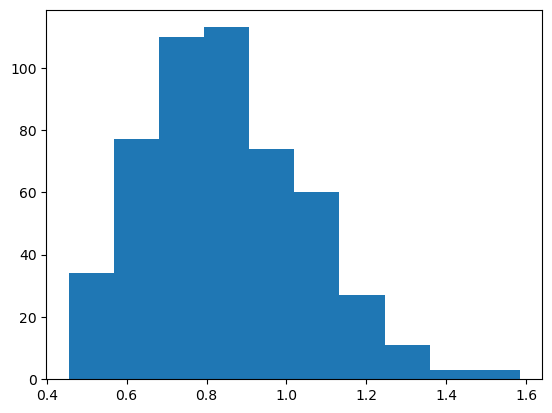

In [108]:
plt.hist(vfeatures_mean)

In [105]:
# # first get model performance with all features
# all_feature_performance = {'f1': 0.32909090909090905, 'roc_auc': 0.7106333347154663, 'accuracy': 0.056530214424951264}
test_dataloader = DataLoader(test_ds, collate_fn=collate_fn, batch_size=32)
all_feature_performance = evaluate(test_dataloader, threshold=thresholds, verbose=0)
test_dataloader_male = DataLoader(test_ds_male, collate_fn=collate_fn, batch_size=32)
all_feature_perf_male = evaluate(test_dataloader_male, threshold=thresholds, verbose=0)
test_dataloader_female = DataLoader(test_ds_female, collate_fn=collate_fn, batch_size=32)
all_feature_perf_female = evaluate(test_dataloader_female, threshold=thresholds, verbose=0)

  0%|          | 0/17 [00:00<?, ?batch/s]

  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

In [100]:

# # Forward pass through the feature extractor
model.eval()

feature_shape = 512
importances = []
for i in tqdm(vfeature_imp_idx): # there are in total 512 features
    masker = torch.ones(feature_shape, dtype=torch.float32).to(device)
    masker[i] = 0.0
    with torch.no_grad():
        v_y_true = torch.tensor([], dtype=torch.long)
        v_y_pred = torch.tensor([])
        for _, vdata in enumerate(test_dataloader):
            vinputs, vlabels = vdata['pixel_values'], vdata['labels'].cpu()
            voutputs = feature_extractor(vinputs)
            vfeatures_maked = voutputs['features'] * masker
            vprobs = model.resnet.fc(vfeatures_maked)
            v_y_pred = torch.cat((v_y_pred, vprobs.cpu()), 0)
            v_y_true = torch.cat((v_y_true, vlabels), 0)
        masked_preformance = multi_label_metrics(v_y_pred, v_y_true.numpy(), threshold=thresholds, verbose=0)
        importances.append(all_feature_performance['f1'] - masked_preformance['f1'])
        

  0%|          | 0/28 [00:00<?, ?it/s]

In [103]:
importances[np.argmax(importances)]

0.0029647829647829194

In [74]:
from scipy import stats
gender_test_ds = [int(x['Patient Gender'] == 'M') for x in test_ds]

# for i in range(vfeatures.shape[1]):
#     vfeatures[:, i]

In [86]:
from scipy import stats
features_pearsonr = []
for i in range(512):
    v = vfeatures.numpy()[:, i]
    v = np.where(v > np.mean(v), 1.0, 0)
    features_pearsonr.append(stats.pearsonr(gender_test_ds, v))

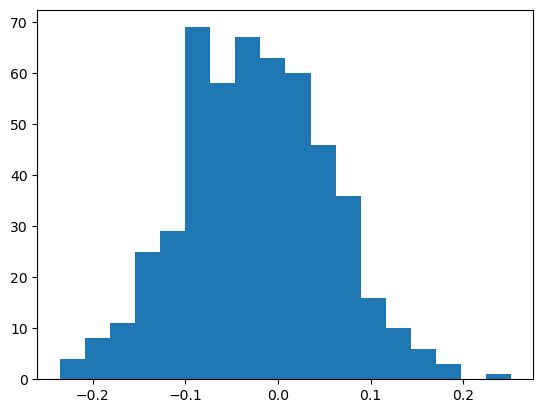

In [95]:
features_pearsonr_v = [x[0] for x in features_pearsonr]
plt.hist(features_pearsonr_v, bins='auto') 
vfeature_imp_idx = np.argsort(-np.array(features_pearsonr_v))[:10]

In [99]:
# # ## An example to show how to perturbation the immediate feature.

# from torch import nn

# class cls_model(nn.Module):
#     def __init__(self):
#         super(cls_model,self).__init__()
#         self.l1 = nn.Linear(3,2)
#         self.l2 = nn.Linear(2,4)
#         self.l3 = nn.Linear(4,5)
#     def forward(self, x):
#         y1 = self.l1(x)
#         y2 = self.l2(y1)
#         y3 = self.l3(y2)
#         return y3
    
# def forward_hook(module, input, output):
#     print(f"Inside forward hook for {module.__class__.__name__}")
#     print(f"Input shape: {input[0].shape}")
#     print(f"Output shape: {output.shape}")
#     print("--------")
#     return torch.zeros(output.shape)
# model_cls = cls_model()
# hook_handle = model_cls.l2.register_forward_hook(forward_hook)
# x = torch.randn((6,3))
# model.forward(x)

Inside forward hook for Linear
Input shape: torch.Size([6, 2])
Output shape: torch.Size([6, 4])
--------


tensor([[-0.0275,  0.3476, -0.1044, -0.4723,  0.2896],
        [-0.0275,  0.3476, -0.1044, -0.4723,  0.2896],
        [-0.0275,  0.3476, -0.1044, -0.4723,  0.2896],
        [-0.0275,  0.3476, -0.1044, -0.4723,  0.2896],
        [-0.0275,  0.3476, -0.1044, -0.4723,  0.2896],
        [-0.0275,  0.3476, -0.1044, -0.4723,  0.2896]],
       grad_fn=<AddmmBackward0>)